# Pneumonia Detection

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Set all the Constants

In [52]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

### Import data into tensorflow dataset object

In [55]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5856 files belonging to 2 classes.


In [56]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [57]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualizing some of the images from our dataset

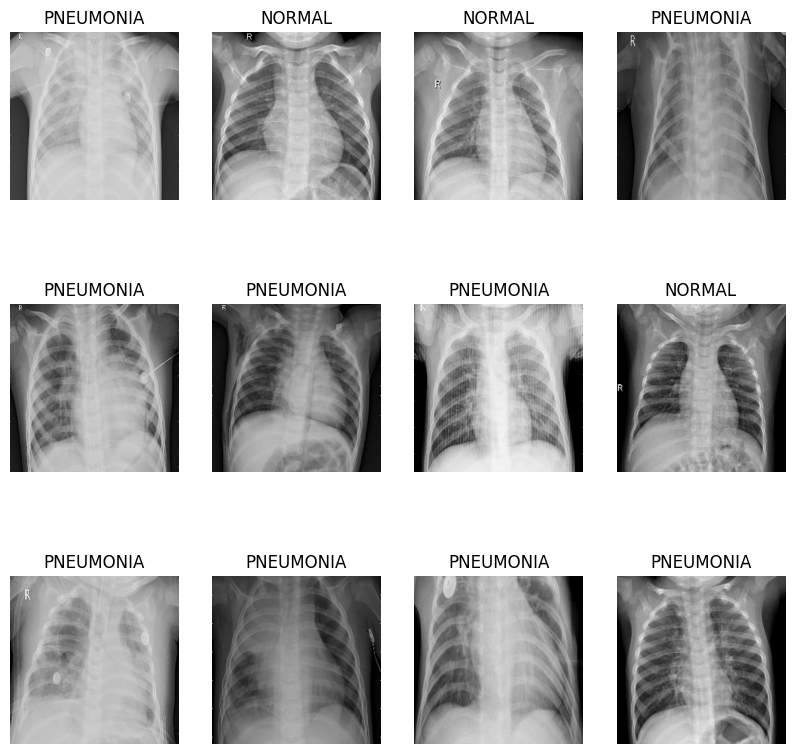

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

183

In [58]:
train_size = 0.7
len(dataset)*train_size

128.1

In [59]:
train_ds = dataset.take(128)
len(train_ds)

128

In [60]:
test_ds = dataset.skip(128)
len(test_ds)

55

In [61]:
val_size=0.15
len(dataset)*val_size

27.45

In [62]:
val_ds = test_ds.take(27)
len(val_ds)

27

In [63]:
test_ds = test_ds.skip(27)
len(test_ds)

28

In [65]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [66]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
len(train_ds)

128

In [39]:
len(val_ds)

27

In [40]:
len(test_ds)

28

### Cache, Shuffle, and Prefetch the Dataset

In [67]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [69]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [70]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [71]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



**Watch below video if you are not familiar with data augmentation**

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [72]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [73]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [36]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
else:
    print("No GPUs detected by TensorFlow.")


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [75]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [76]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
128/128 [==============================] - 254s 2s/step - loss: 0.5164 - accuracy: 0.7705 - val_loss: 0.8305 - val_accuracy: 0.7523
Epoch 2/30
128/128 [==============================] - 77s 600ms/step - loss: 0.2799 - accuracy: 0.8816 - val_loss: 1.7160 - val_accuracy: 0.7627
Epoch 3/30
128/128 [==============================] - 73s 572ms/step - loss: 0.2216 - accuracy: 0.9136 - val_loss: 1.3558 - val_accuracy: 0.7778
Epoch 4/30
128/128 [==============================] - 68s 529ms/step - loss: 0.2147 - accuracy: 0.9194 - val_loss: 1.9957 - val_accuracy: 0.7731
Epoch 5/30
128/128 [==============================] - 68s 527ms/step - loss: 0.1900 - accuracy: 0.9307 - val_loss: 1.1555 - val_accuracy: 0.7326
Epoch 6/30
128/128 [==============================] - 65s 504ms/step - loss: 0.1917 - accuracy: 0.9319 - val_loss: 0.5604 - val_accuracy: 0.8137
Epoch 7/30
128/128 [==============================] - 65s 511ms/step - loss: 0.1795 - accuracy: 0.9355 - val_loss: 0.8603 - val_accu

In [78]:
scores = model.evaluate(test_ds)

28/28 [==============================] - 2s 59ms/step - loss: 0.3913 - accuracy: 0.8705


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [79]:
scores

[0.3913085162639618, 0.8705357313156128]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [80]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [81]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 128}

In [82]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [83]:
type(history.history['loss'])

list

In [84]:
len(history.history['loss'])

30

In [86]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.5164082050323486,
 0.2798682451248169,
 0.22158567607402802,
 0.21472495794296265,
 0.190024733543396]

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

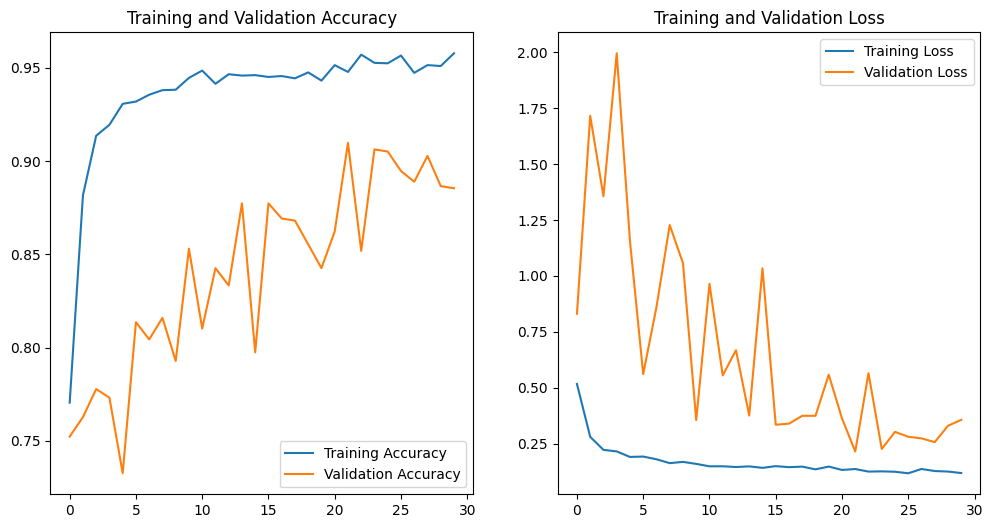

In [88]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: PNEUMONIA
1/1 [==============================] - 1s 906ms/step
predicted label: PNEUMONIA


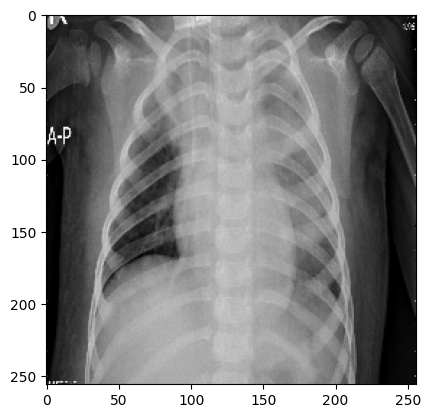

In [89]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [92]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 49ms/step


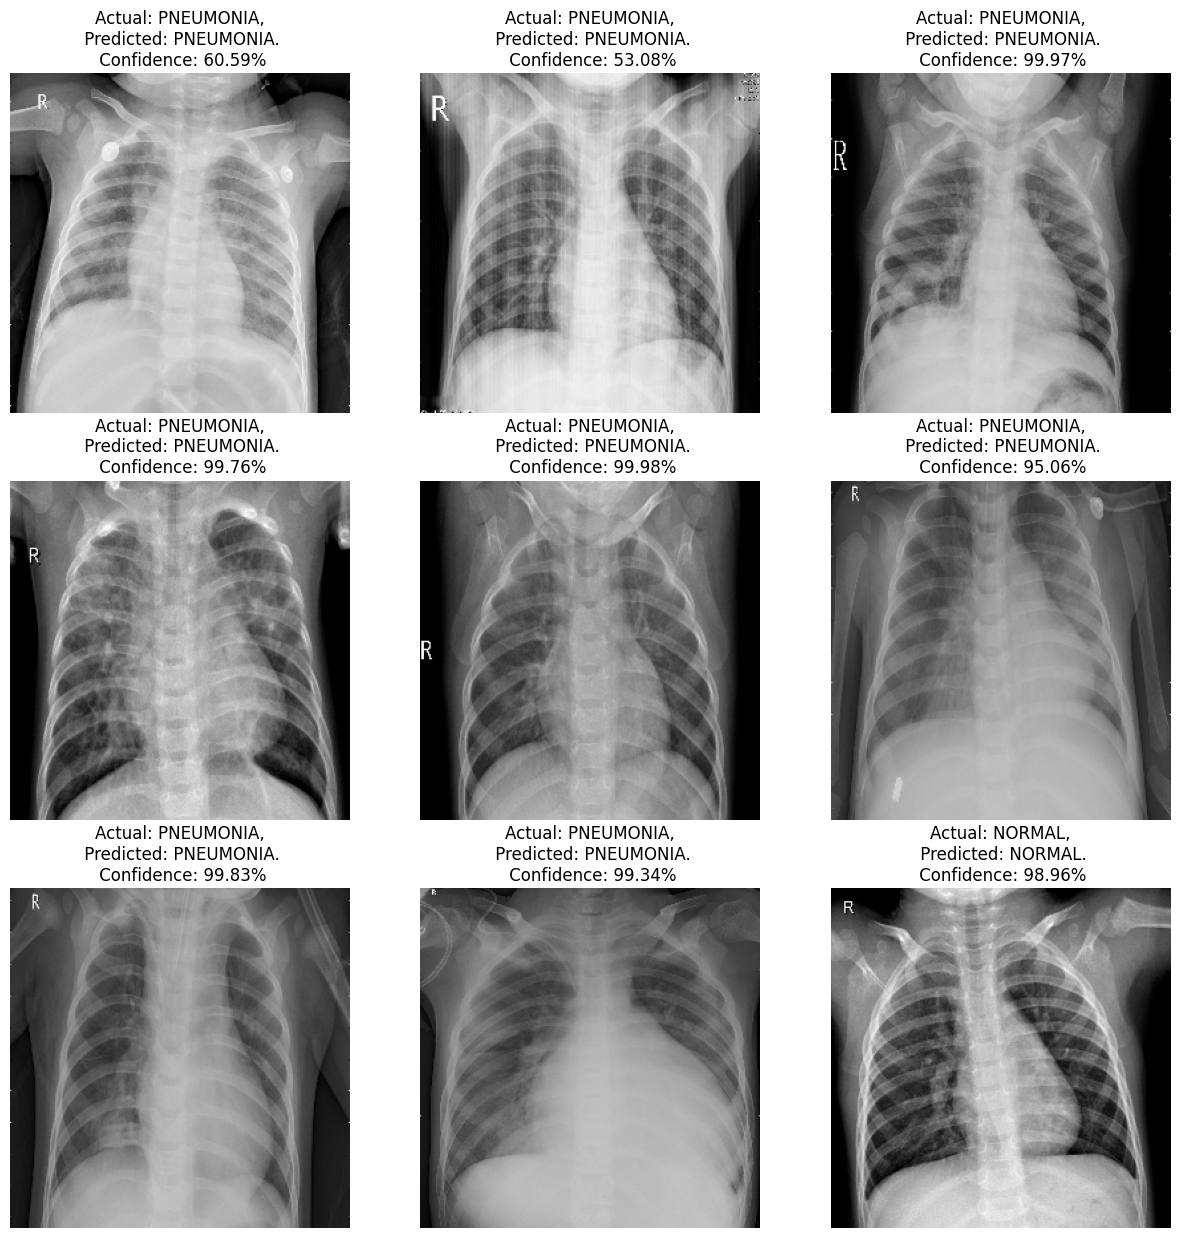

In [94]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [95]:
import os
model_version=max([int(i) for i in os.listdir("../saved_model") + [0]])+1
model.save(f"../saved_model/{model_version}")

INFO:tensorflow:Assets written to: ../saved_model/3\assets


INFO:tensorflow:Assets written to: ../saved_model/3\assets


In [96]:
model.save("../potatoes.h5")